In [1]:
# Optimizing Smart Grid Energy Distribution using CUDA-Accelerated Genetic Algorithm

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd

In [2]:
# ==== 1. GRID CONFIGURATION ====
num_nodes = 500
num_sources = 3
hours = 24

torch.manual_seed(42)

# Demand matrix with dynamic patterns based on time-of-day, consumer type, and weekday/weekend
time_factors = torch.tensor([1.3 if 7 <= h <= 9 or 18 <= h <= 21 else 0.9 for h in range(hours)])
weekday_factors = torch.tensor([1.0 if i % 7 < 5 else 0.8 for i in range(hours)])
consumer_types = torch.randint(1, 4, (num_nodes, 1)).float()
base_demand = torch.randint(50, 120, (num_nodes, hours), dtype=torch.float32)
demand = base_demand * time_factors * weekday_factors + (consumer_types * 10)
demand = demand.clamp(min=50, max=300)

# Storage constraints per node
storage_limits = torch.randint(100, 500, (num_nodes,), dtype=torch.float32)

# Source capacity and cost with dynamic patterns
base_source_capacity = torch.tensor([8000, 5000, 7000], dtype=torch.float32)
solar_profile = torch.tensor([0.1 if h < 6 or h > 18 else 1.0 for h in range(hours)])
wind_profile = torch.tensor([0.6 + 0.3 * np.sin(h / 24 * 2 * np.pi) for h in range(hours)])
hydro_profile = torch.tensor([1.0 for _ in range(hours)])

dynamic_source_capacity = torch.stack([
    base_source_capacity[0] * solar_profile,
    base_source_capacity[1] * wind_profile,
    base_source_capacity[2] * hydro_profile
])

peak_hours = torch.tensor([1.5 if h in range(7, 10) or h in range(18, 22) else 1.0 for h in range(hours)])

source_cost = torch.tensor([0.10, 0.15, 0.12], dtype=torch.float32)
loss_coef = torch.rand((num_nodes, num_sources)) * 0.02 + 0.01

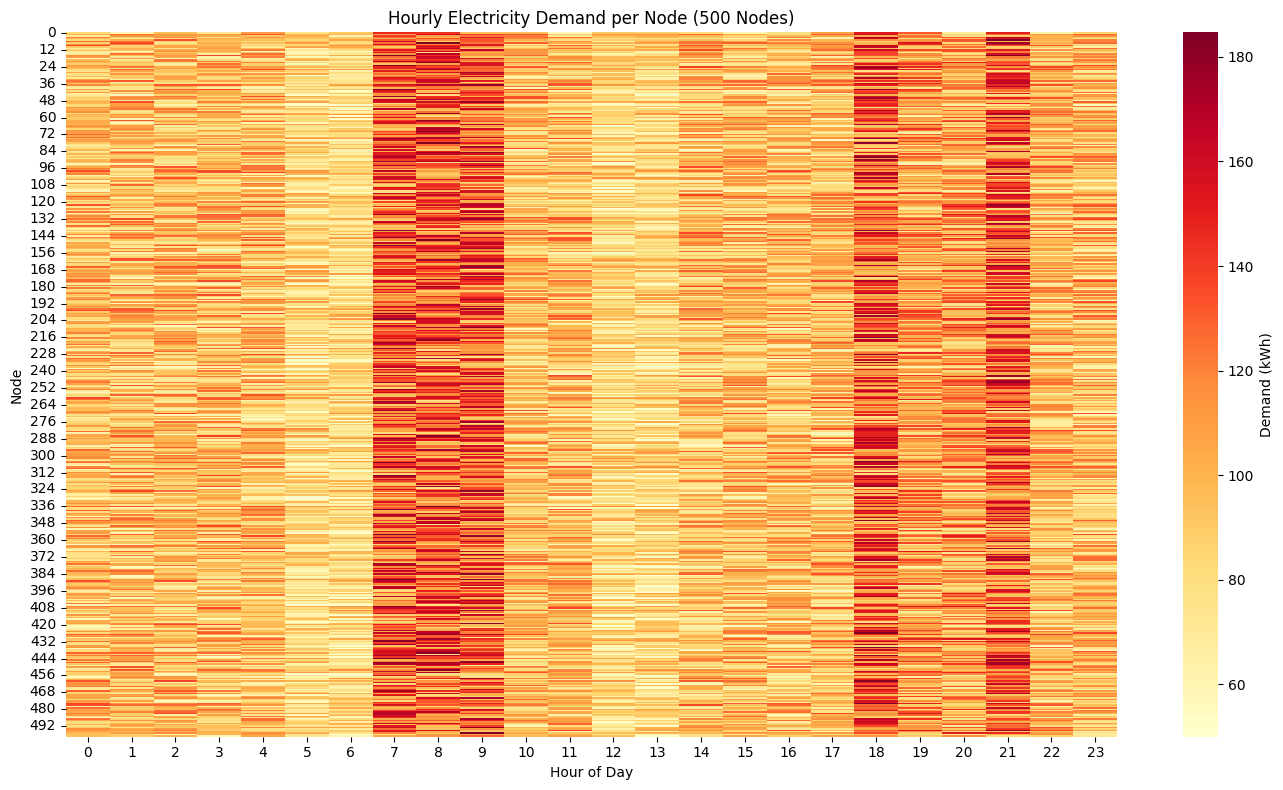

In [3]:
# ==== 2. VISUALIZE DEMAND ====
plt.figure(figsize=(14, 8))
sns.heatmap(demand.numpy(), cmap="YlOrRd", cbar_kws={'label': 'Demand (kWh)'})
plt.xlabel("Hour of Day")
plt.ylabel("Node")
plt.title("Hourly Electricity Demand per Node (500 Nodes)")
plt.tight_layout()
plt.show()

In [4]:
# ==== 3. GA PARAMETERS ====
population_size = 512
generations = 300
gene_length = num_nodes * num_sources * hours

crossover_rate = 0.9
mutation_rate = 0.05

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# ==== 4. INIT POPULATION ====
def init_population(pop_size, length):
    return torch.rand((pop_size, length), device=device)

In [6]:
# ==== 5. FITNESS FUNCTION ====
def compute_fitness(pop):
    pop_reshaped = pop.view(pop.size(0), num_nodes, num_sources, hours)
    losses = pop_reshaped * loss_coef.to(device).unsqueeze(-1)
    net_energy = pop_reshaped - losses

    total_supplied = net_energy.sum(dim=2)
    demand_rep = demand.to(device).unsqueeze(0)
    under = torch.relu(demand_rep - total_supplied)
    over = torch.relu(total_supplied - demand_rep)

    demand_penalty = (under ** 2).sum(dim=(1, 2))
    oversupply_penalty = (over ** 2).sum(dim=(1, 2))

    storage_use = over.sum(dim=2)
    storage_limits_rep = storage_limits.to(device).unsqueeze(0).repeat(pop.size(0), 1)
    storage_penalty = torch.relu(storage_use - storage_limits_rep).sum(dim=1)

    dynamic_capacity = dynamic_source_capacity.to(device).unsqueeze(0).repeat(pop.size(0), 1, 1)
    supply_totals = pop_reshaped.sum(dim=1)
    supply_penalty = torch.relu(supply_totals - dynamic_capacity).sum(dim=(1, 2))

    cost_matrix = pop_reshaped * source_cost.to(device).view(1, 1, -1, 1) * peak_hours.to(device).view(1, 1, 1, -1)
    total_cost = cost_matrix.sum(dim=(1, 2, 3))

    fitness = - (total_cost + 0.1 * demand_penalty + 0.05 * oversupply_penalty +
                 0.05 * supply_penalty + 0.03 * storage_penalty)
    return fitness

In [7]:
# ==== 6. CROSSOVER & MUTATION ====
def crossover(parent1, parent2):
    mask = torch.rand_like(parent1) < 0.5
    return torch.where(mask, parent1, parent2)

def mutate(child):
    mutation = torch.rand_like(child) < mutation_rate
    noise = torch.rand_like(child) * 0.1
    return torch.where(mutation, child + noise, child)

In [8]:
# ==== 7. RUN GA PARALLEL ====
def run_ga_parallel():
    population = init_population(population_size, gene_length)
    best_fitness = []
    avg_fitness = []

    for gen in range(generations):
        fitness = compute_fitness(population)
        best_fitness.append(fitness.max().item())
        avg_fitness.append(fitness.mean().item())

        probs = (fitness - fitness.min()) + 1e-6
        probs = probs / probs.sum()
        parents_idx = torch.multinomial(probs, population_size, replacement=True)
        parents = population[parents_idx]

        next_gen = []
        for i in range(0, population_size, 2):
            if torch.rand(1).item() < crossover_rate:
                child1 = crossover(parents[i], parents[i+1])
                child2 = crossover(parents[i+1], parents[i])
            else:
                child1, child2 = parents[i], parents[i+1]

            next_gen.append(mutate(child1))
            next_gen.append(mutate(child2))

        population = torch.stack(next_gen).clamp(0, dynamic_source_capacity.max().item())

    return best_fitness, avg_fitness

In [9]:
# ==== 8. RUN GA SERIAL ====
def run_ga_serial():
    population = init_population(population_size, gene_length).cpu()
    best_fitness = []

    for gen in range(generations):
        fitness = compute_fitness(population.to(device)).cpu()
        best_fitness.append(fitness.max().item())

        probs = (fitness - fitness.min()) + 1e-6
        probs = probs / probs.sum()
        parents_idx = torch.multinomial(probs, population_size, replacement=True)
        parents = population[parents_idx]

        next_gen = []
        for i in range(0, population_size, 2):
            if np.random.rand() < crossover_rate:
                child1 = crossover(parents[i], parents[i+1])
                child2 = crossover(parents[i+1], parents[i])
            else:
                child1, child2 = parents[i], parents[i+1]

            next_gen.append(mutate(child1))
            next_gen.append(mutate(child2))

        population = torch.stack(next_gen).clamp(0, dynamic_source_capacity.max().item())

    return best_fitness

In [10]:
# ==== 9. EXECUTE AND TIME ====
start = time.time()
gpu_best_fitness, gpu_avg_fitness = run_ga_parallel()
gpu_time = time.time() - start

start = time.time()
cpu_best_fitness = run_ga_serial()
cpu_time = time.time() - start

print(f"GPU Time: {gpu_time:.2f}s | CPU Time: {cpu_time:.2f}s")
speedup = cpu_time / gpu_time
print(f"GPU Speedup Factor: {speedup:.2f}x")

GPU Time: 17.10s | CPU Time: 117.90s
GPU Speedup Factor: 6.89x


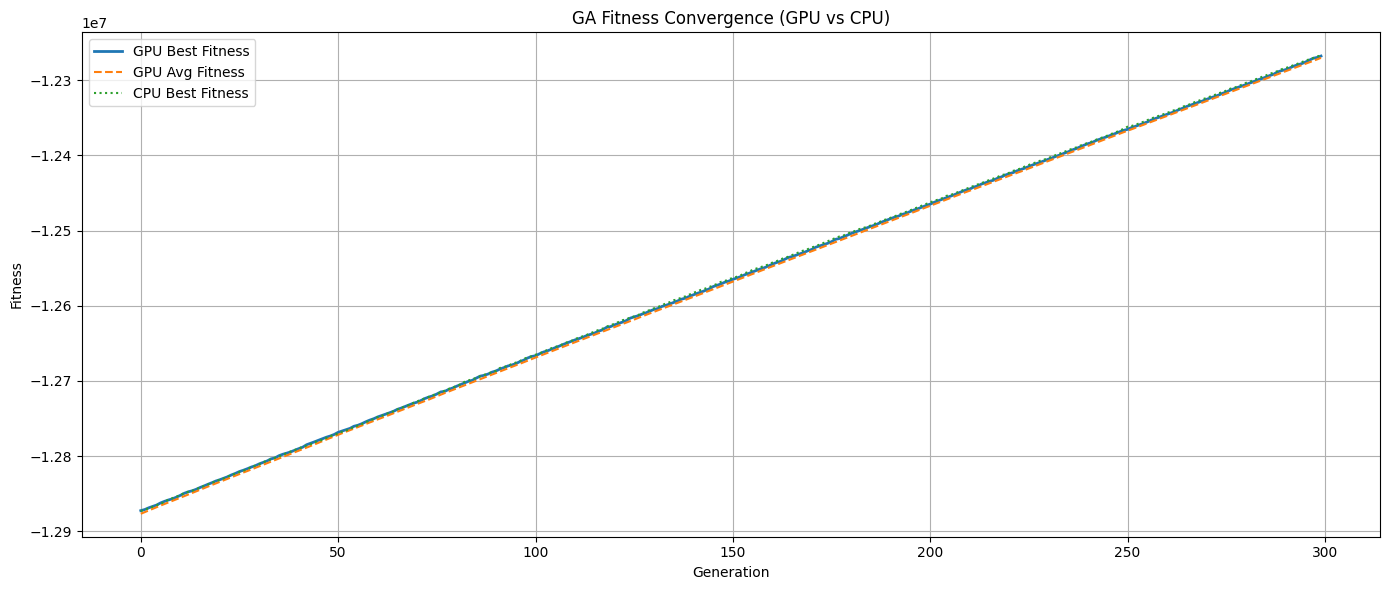

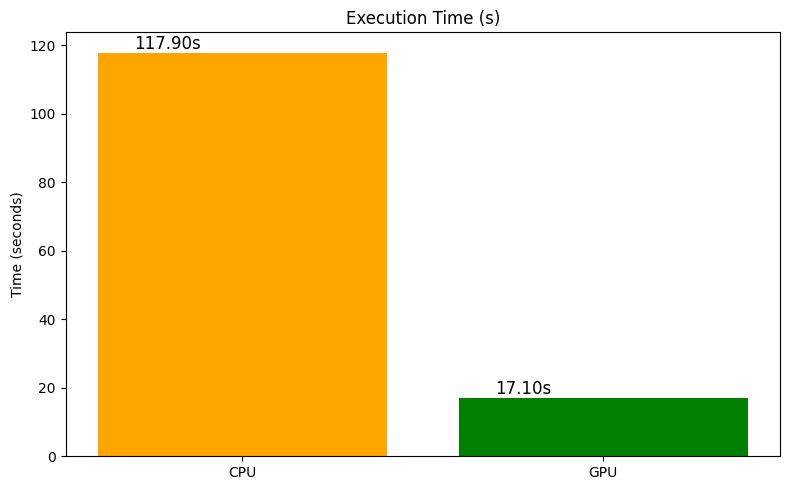

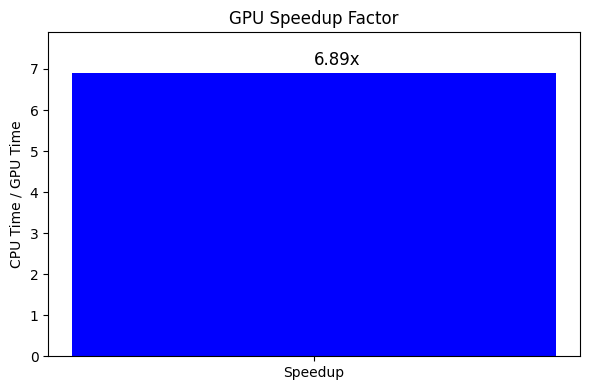

In [11]:
# ==== 10. VISUALIZATION ====
plt.figure(figsize=(14, 6))
plt.plot(gpu_best_fitness, label='GPU Best Fitness', linewidth=2)
plt.plot(gpu_avg_fitness, label='GPU Avg Fitness', linestyle='--')
plt.plot(cpu_best_fitness, label='CPU Best Fitness', linestyle=':')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('GA Fitness Convergence (GPU vs CPU)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
labels = ['CPU', 'GPU']
times = [cpu_time, gpu_time]
bars = plt.bar(labels, times, color=['orange', 'green'])
plt.title('Execution Time (s)')
plt.ylabel('Time (seconds)')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.1, yval + 1, f'{yval:.2f}s', fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(['Speedup'], [speedup], color='blue')
plt.ylabel('CPU Time / GPU Time')
plt.title('GPU Speedup Factor')
plt.ylim(0, max(speedup + 1, 5))
plt.text(0, speedup + 0.2, f'{speedup:.2f}x', fontsize=12)
plt.tight_layout()
plt.show()